In [18]:
import os
import io
import time
import pickle
import itertools 
import pandas as pd
import numpy as np
import scipy

import cv2
from skimage import transform
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import autocast, GradScaler


from Datasets import *

image_dir = r"I:\AVA_images"
pkl_dir= r"H:\AVAFeatures_pkl"
feature_dir = r'H:\AVA Featuremaps'
csv_dir = r"C:\Users\Leo's PC\Desktop\AVA.txt"
checkpoint_save_dir = r"I:\Model Checkpoints"
cache_folder = r"I:\AVACache_Smooth"

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

255502 images found in the feature map directory.
19999 images are found within the specified range
Extremes: ('17640', 1.1810344827586208) ('491369', 7.399253731343284)
1999 images with label 0. 2000 images with label 1.


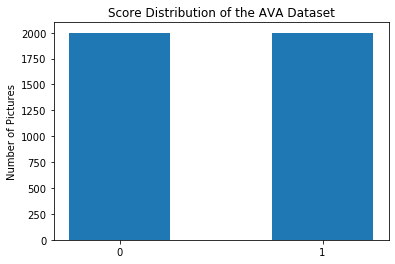

In [20]:
# Train = AVAFeatureDataset_Binary_percent(csv_file=csv_dir, file_dir=feature_dir, pkl_dir=pkl_dir, start=0, end=209999, percent=0.5, transform=transforms.Compose([Rescale_list((224, 224)), ToNumpy_list()]))
# Validation = AVAFeatureDataset_Binary_percent(csv_file=csv_dir, file_dir=feature_dir, pkl_dir=pkl_dir, start=210000, end=229999, percent=0.5, transform=transforms.Compose([Rescale_list((224, 224)), ToNumpy_list()]))
Test = AVAFeatureDataset_Binary_percent(csv_file=csv_dir, file_dir=feature_dir, pkl_dir=pkl_dir, start=230000, end=249999, percent=0.1, transform=transforms.Compose([Rescale_list((224, 224)), ToNumpy_list()]))

In [8]:
Validation.CACHED_TRANSFORM, Validation.CACHED, Train.CACHED_TRANSFORM, Train.CACHED = True, True, True, True

In [21]:
# Train.build_cache(r'I:\AVACache_Binary50%', TRANSFORM=True)
# Validation.build_cache(r'I:\AVACache_Binary50%', TRANSFORM=True)
Test.build_cache(r'I:\AVACache_Binary10%', TRANSFORM=True)

Start building cache
Cacheing complete. Took 318.4704387187958 seconds.


In [5]:
print(Train.__len__())

209999


In [23]:
with open('I:\AVA_dataset_pkl/test_features_10%_Cached.pkl', 'wb') as fp:
    pickle.dump(Test, fp)

# Load Dataset and Create Dataloader

In [2]:
with open('I:\AVA_dataset_pkl/train_features_10%_binary_Cached.pkl', 'rb') as fp:
    Train = pickle.load(fp)
    
with open('I:\AVA_dataset_pkl/validation_features_10%_binary_Cached.pkl', 'rb') as fp:
    Validation = pickle.load(fp)

with open('I:\AVA_dataset_pkl/test_features_10%_Cached.pkl', 'rb') as fp:
    Test = pickle.load(fp)

In [24]:
batch_size = 32
train_loader = DataLoader(dataset=Train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=Validation, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=Test, batch_size=batch_size, shuffle=False)

In [4]:
print(len(next(enumerate(train_loader))[1]['image']))

20


# Model Class

In [5]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


class DeepFeaturesProcessor(nn.Module):
    def __init__(self):
        super(DeepFeaturesProcessor, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=19, out_channels=32, kernel_size=[7,7], stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=[5,5], stride=2, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        
        self.activation = nn.ReLU()
        
    @autocast()   
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

    
class SceneProcessor(nn.Module):
    def __init__(self):
        super(SceneProcessor, self).__init__()
        
        self.fc = nn.Linear(2048, 1024)
        self.activation = nn.ReLU()

    @autocast()    
    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x
    

class AugmentedDenseNet(nn.Module):
    
    
    def __init__(self):
        super(AugmentedDenseNet, self).__init__()
        
        self.densenet = torchvision.models.densenet121(pretrained=True, progress=True).features
        self.deep_feature_processor = DeepFeaturesProcessor()
        self.scene_processor = SceneProcessor()
        
        self.pre_input = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=[7,7], stride=2, padding=3)
        
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=[7,7], stride=2, padding=3)
        self.pool0 = nn.AdaptiveMaxPool2d(output_size=56)
        self.dense_input = nn.Sequential(self.conv0, self.densenet.norm0, nn.ReLU(), self.pool0)
        self.dense_block1 = self.densenet.denseblock1
        self.dense_block2 = self.densenet.denseblock2
        self.dense_block3 = self.densenet.denseblock3
        self.dense_block4 = self.densenet.denseblock4
        
        self.dense_transition1 = self.densenet.transition1 
        self.dense_transition2 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=192, kernel_size=[1,1], stride=1, padding=0),
                                               nn.ReLU(),
                                               nn.AvgPool2d(kernel_size = [2, 2], stride=2, padding=0))
        self.dense_transition3 = self.densenet.transition3

        self.pooling = nn.AvgPool2d(kernel_size = [7, 7], stride=7, padding=0)
        
        self.fc1 = nn.Linear(2048, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 2)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.bn1d1 = nn.BatchNorm1d(2048)
        self.bn1d2 = nn.BatchNorm1d(1024)
        
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
        self.scene_processor.apply(init_weights)
        self.deep_feature_processor.apply(init_weights)
        self.pre_input.apply(init_weights)

        
    @autocast()
    def forward(self, imagelist, scene, device):
        
        #self.densenet = self.densenet.to(device)
        #self.deep_feature_processor = self.deep_feature_processor.to(device)
        #self.scene_processor = self.scene_processor.to(device)
        
        # original_input = torch.from_numpy(imagelist[0])
        original_input = imagelist[0].float()
        #original_input = original_input.to(device)
        dense_feature_out = self.pre_input(original_input)
        dense_feature_out = self.dense_input(dense_feature_out)
        dense_feature_out = self.dense_block1(dense_feature_out)
        dense_feature_out = self.dense_transition1(dense_feature_out)
        dense_feature_out = self.dense_block2(dense_feature_out)
        dense_feature_out = self.dense_transition2(dense_feature_out)
        
        deep_feature_in = []
        for feature in imagelist[1:20]:
            feature = feature.float()
            #feature = feature.to(device)
            deep_feature_in.append(feature)
        deep_feature_in = torch.cat(deep_feature_in, dim=1)
        
        deep_feature_out = self.deep_feature_processor(deep_feature_in)
        dense_in = torch.cat([dense_feature_out, deep_feature_out], dim=1)
        
        dense_out = self.dense_block3(dense_in)
        dense_out = self.dense_transition3(dense_out)
        dense_out = self.dense_block4(dense_out)
        dense_out = self.pooling(dense_out)
        dense_out = dense_out.view(dense_out.size()[0], -1)
        
        # scene_input = torch.from_numpy(scene)
        scene_input = scene.float()
        #scene_input = scene_input.to(device)
        scene_out = self.scene_processor(scene_input)
        fc_in = torch.cat([dense_out, scene_out], dim=1)
        
        fc_out = self.fc1(fc_in)
        fc_out = self.bn1d1(fc_out)
        fc_out = self.dropout1(fc_out)
        fc_out = self.relu(fc_out)
        fc_out = self.fc2(fc_out)
        fc_out = self.bn1d2(fc_out)
        fc_out = self.dropout2(fc_out)
        fc_out = self.relu(fc_out)
        fc_out = self.fc3(fc_out)
        fc_out = self.relu(fc_out)
        fc_out = self.fc4(fc_out)
        fc_out = self.softmax(fc_out)
        
        return fc_out

    def name(self):
        return "FeatureNet"

In [6]:
class DeepFeaturesProcessor_Light(nn.Module):
    def __init__(self):
        super(DeepFeaturesProcessor_Light, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=19, out_channels=32, kernel_size=[7,7], stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=[5,5], stride=2, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.activation = nn.ReLU()
        
    @autocast()   
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.activation(x)
        
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.activation(x)
        
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.activation(x)
        
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.activation(x)
        
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.activation(x)
        
        x = self.pool5(x)
        
        return x


class AugmentedLightNet(nn.Module):
    
    
    def __init__(self):
        super(AugmentedLightNet, self).__init__()
        
        self.densenet = torchvision.models.densenet121(pretrained=True, progress=True).features
        self.deep_feature_processor = DeepFeaturesProcessor_Light()
        self.scene_processor = SceneProcessor()
        
        self.pre_input = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=[7,7], stride=2, padding=3)
        
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=[7,7], stride=2, padding=3)
        self.pool0 = nn.AdaptiveMaxPool2d(output_size=56)
        self.dense_input = nn.Sequential(self.conv0, self.densenet.norm0, nn.ReLU(), self.pool0)
        self.dense_block1 = self.densenet.denseblock1
        self.dense_block2 = self.densenet.denseblock2
        self.dense_block3 = self.densenet.denseblock3
        self.dense_block4 = self.densenet.denseblock4
        
        self.dense_transition1 = self.densenet.transition1 
        self.dense_transition2 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=192, kernel_size=[1,1], stride=1, padding=0),
                                               nn.ReLU(),
                                               nn.AvgPool2d(kernel_size = [2, 2], stride=2, padding=0))
        self.dense_transition3 = self.densenet.transition3

        self.pooling = nn.AvgPool2d(kernel_size = [7, 7], stride=7, padding=0)
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.bn1d1 = nn.BatchNorm1d(2048)
        self.bn1d2 = nn.BatchNorm1d(1024)
        
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
        self.scene_processor.apply(init_weights)
        self.deep_feature_processor.apply(init_weights)
        self.pre_input.apply(init_weights)

        
    @autocast()
    def forward(self, imagelist, scene, device):
        
        deep_feature_in = []
        
        for feature in imagelist[1:20]:
            feature = feature.float()
            deep_feature_in.append(feature)
            
        deep_feature_in = torch.cat(deep_feature_in, dim=1)
        
        deep_feature_out = self.deep_feature_processor(deep_feature_in)

        deep_feature_out = deep_feature_out.view(dense_out.size()[0], -1)
        

        scene_input = scene.float()

        scene_out = self.scene_processor(scene_input)
        
        fc_in = torch.cat([deep_feature_out, scene_out], dim=1)
        
        fc_out = self.fc1(fc_in)
        fc_out = self.bn1d1(fc_out)
        fc_out = self.dropout1(fc_out)
        fc_out = self.relu(fc_out)
        
        fc_out = self.fc2(fc_out)
        fc_out = self.bn1d2(fc_out)
        fc_out = self.dropout2(fc_out)
        fc_out = self.relu(fc_out)
        
        fc_out = self.fc3(fc_out)
        fc_out = self.sigmoid(fc_out)
        
        return fc_out

    def name(self):
        return "FeatureNet"

# Model Initialization & Hyperparameters

In [7]:
model = AugmentedDenseNet()

In [8]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()

In [11]:
for p in model.module.dense_input.parameters():
    p.requires_grad == False

for p in model.module.dense_block1.parameters():
    p.requires_grad == False
        
for p in model.module.dense_block2.parameters():
    p.requires_grad == False
        
for p in model.module.dense_transition1.parameters():
    p.requires_grad == False
        
for p in model.module.dense_transition2.parameters():
    p.requires_grad == False
    
'''
for p in model.module.deep_feature_processor.parameters():
    p.requires_grad == False
    
for p in model.module.pre_input.parameters():
    p.requires_grad == False
    
for p in model.module.dense_block3.parameters():
    p.requires_grad == False
        
for p in model.module.dense_block4.parameters():
    p.requires_grad == False
        
for p in model.module.dense_transition3.parameters():
    p.requires_grad == False
'''

'\nfor p in model.module.deep_feature_processor.parameters():\n    p.requires_grad == False\n    \nfor p in model.module.pre_input.parameters():\n    p.requires_grad == False\n    \nfor p in model.module.dense_block3.parameters():\n    p.requires_grad == False\n        \nfor p in model.module.dense_block4.parameters():\n    p.requires_grad == False\n        \nfor p in model.module.dense_transition3.parameters():\n    p.requires_grad == False\n'

### Initialization for single-GPU/CPU training ONLY

In [44]:
model = model.cuda()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

RuntimeError: CUDA error: device-side assert triggered

### Initialization for Data Parallel training ONLY

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.cuda()
model = torch.nn.DataParallel(model)

### Automatic mixed-percision

In [12]:
scaler = GradScaler()

# Training Code

In [13]:
training_stats = {}
training_stats['tarining_loss'] = []
training_stats['validation_loss'] = []
training_stats['accuracy'] = []
training_stats['RMSE'] = []
training_stats['spearmanr'] = []
training_stats['classification'] = []

In [14]:
def save_checkpt(model_name, save_dir, epoch, model, optimizer, loss, accu, training_stats):
    checkpoint_file = open(save_dir + "\\" + model_name + "_" + "E" + str(epoch) + "A" + str(int(accu*1000)) + "_" + time.strftime("%m.%d.%Y_%H.%M.%S") 
                       + ".tar", 'wb')
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'training_stats': training_stats,
            }, checkpoint_file)
    checkpoint_file.close()


model_name = "DenseNet_Augmented_Binary_Paper"
checkpoint_save_dir = r"I:\Model Checkpoints"
best_accu = 0.0

## Binary Classification

In [29]:
global epoch #declear epoch global, to be used later by torch.save() 
breakflag = False
VALIDATION_FIRST = True

for epoch in range(1):
    
    ave_loss = 0
    global loss #declear loss global, to be used later by torch.save() 


    if epoch == 0 and VALIDATION_FIRST:
        
        f1_eval_storage = {'prediction':[], 'target':[]}
        correct, ave_loss, total_cnt = 0, 0, 0
        
        for batch_idx, diction in enumerate(test_loader):
            model.eval() #set model to evaluation mode
        
            imagelist, scene, target = diction['image'], diction['scene'], diction['rating'] #extract training data for this batch

            target = target.to(device) 
            target = Variable(target)
            target = target.float()

            with autocast():
                out = model(imagelist, scene, device=device) #forward pass
                loss = criterion(out, target.long()) #calculate loss

            pred_label = out.data
            pred_label = pred_label.argmax(dim=1, keepdim=True)

            target = target.long()

            f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], pred_label.cpu().detach().numpy())
            f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())

            total_cnt += scene.data.size()[0]
            ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average
            correct += pred_label.eq(target.view_as(pred_label)).sum().item()

            if (batch_idx + 1) == len(test_loader):
                print(
                '>>> epoch: {}, batch index: {}, test loss ave(E): {:.6f}, acc: {:.6f}'.format(
                    epoch, batch_idx + 1, ave_loss, correct * 1.0 / total_cnt))
                print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))
                print('==================================================================') 

                #training_stats['accuracy'].append(correct * 1.0 / total_cnt)
                #training_stats['validation_loss'].append(ave_loss)
                #training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))
            
                #save_checkpt(model_name, checkpoint_save_dir, epoch, model, optimizer, loss, accu=(correct * 1.0 / total_cnt), training_stats=training_stats)
          
 
    for batch_idx, diction in enumerate(train_loader):
        model.train() #set model to traning mode
        optimizer.zero_grad()
        
        imagelist, scene, target = diction['image'], diction['scene'], diction['rating'] #extract training data for this batch
        
        target = target.to(device) 
        target = Variable(target)
        target = target.float()

        with autocast():
            out = model(imagelist, scene, device=device) #forward pass
            loss = criterion(out, target.long()) #calculate loss

        ave_loss = ave_loss * 0.99 + loss.item() * 0.01 
        
        scaler.scale(loss).backward() #back propagation with calculated loss
        scaler.step(optimizer) 
        scaler.update()

        if (batch_idx + 1) == len(train_loader):
            print('>>> epoch: {}, batch index: {}, train loss ave(E): {:.6f}'.format(epoch, batch_idx + 1, ave_loss))
            training_stats['tarining_loss'].append(ave_loss)
    
            
    f1_eval_storage = {'prediction':[], 'target':[]}
    correct, ave_loss, total_cnt = 0, 0, 0
    for batch_idx, diction in enumerate(val_loader):
        model.eval() #set model to evaluation mode
        
        imagelist, scene, target = diction['image'], diction['scene'], diction['rating'] #extract training data for this batch
        
        target = target.to(device) 
        target = Variable(target)
        target = target.float()
        
        with autocast():
            out = model(imagelist, scene, device=device) #forward pass
            loss = criterion(out, target.long()) #calculate loss

        pred_label = out.data
        pred_label = pred_label.argmax(dim=1, keepdim=True)
        
        target = target.long()
        
        f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], pred_label.cpu().detach().numpy())
        f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
        
        total_cnt += scene.data.size()[0]
        ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average
        correct += pred_label.eq(target.view_as(pred_label)).sum().item()
        
        if (batch_idx + 1) == len(val_loader):
            print(
            '>>> epoch: {}, batch index: {}, test loss ave(E): {:.6f}, acc: {:.6f}'.format(
                epoch, batch_idx + 1, ave_loss, correct * 1.0 / total_cnt))
            print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))
            print('==================================================================') 
            
            training_stats['accuracy'].append(correct * 1.0 / total_cnt)
            training_stats['validation_loss'].append(ave_loss)
            training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))
            
            save_checkpt(model_name, checkpoint_save_dir, epoch, model, optimizer, loss, accu=(correct * 1.0 / total_cnt), training_stats=training_stats)

>>> epoch: 0, batch index: 125, test loss ave(E): 0.305780, acc: 0.886472
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89      1999
         1.0       0.90      0.87      0.88      2000

    accuracy                           0.89      3999
   macro avg       0.89      0.89      0.89      3999
weighted avg       0.89      0.89      0.89      3999



KeyboardInterrupt: 

## Linear 10 class

In [81]:
global epoch #declear epoch global, to be used later by torch.save() 
VALIDATION_FIRST = True

for epoch in range(20):

    ave_loss = 0
    global loss #declear loss global, to be used later by torch.save() 

    if epoch == 0 and VALIDATION_FIRST:
        
        correct_cnt, ave_loss = 0, 0
        total_cnt = 0
        f1_eval_storage = {'prediction':[], 'target':[], 'pred_label':[]}
        
        for batch_idx, diction in enumerate(test_loader):
            model.eval() #set model to evaluation mode

            imagelist, scene, target = diction['image'], diction['scene'], diction['rating'] #extract training data for this batch
            
            target = target.to(device) 
            target = Variable(target)
            target = target.float()

            with autocast():
                out = model(imagelist, scene, device=device) #forward pass
                loss = criterion(out.squeeze(1), target / 10) #calculate loss

            pred_label = np.around(out.cpu().detach().numpy() * 10)

            target = target.long()
            
            f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], out.cpu().detach().numpy() * 10)
            f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
            f1_eval_storage['pred_label'] = np.append(f1_eval_storage['pred_label'], pred_label)

            total_cnt += scene.data.size()[0]
            # print(out, target.cpu().detach().numpy(), pred_label.squeeze(1))
            correct_cnt += (pred_label.squeeze(1) == target.cpu().detach().numpy()).sum()
            
            ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average

            if (batch_idx + 1) == len(val_loader):
                print(
                '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                    epoch, batch_idx + 1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))

            if (batch_idx + 1) == len(val_loader):
                training_stats['validation_loss'].append(ave_loss)
                training_stats['accuracy'].append(correct_cnt.item() * 1.0 / total_cnt)
                training_stats['RMSE'].append(metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
                training_stats['spearmanr'].append(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
                training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
                print('RMSE:', metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
                print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
                print(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
                print('==================================================================') 
            

    for batch_idx, diction in enumerate(train_loader):
        
        model.train() #set model to traning mode
        optimizer.zero_grad()
        
        imagelist, scene, target = diction['image'], diction['scene'], diction['rating'] #extract training data for this batch
            
        target = target.to(device) 
        target = Variable(target)
        target = target.float()

        with autocast():
            out = model(imagelist, scene, device=device) #forward pass
            loss = criterion(out.squeeze(1), target / 10) #calculate loss
        
        scaler.scale(loss).backward() #back propagation with calculated loss
        scaler.step(optimizer) 
        scaler.update()
        
        ave_loss = ave_loss * 0.999 + loss.item() * 0.001 
        
        if (batch_idx + 1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx + 1, loss))
            training_stats['tarining_loss'].append(ave_loss)
            

    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    f1_eval_storage = {'prediction':[], 'target':[], 'pred_label':[]}
    
    for batch_idx, diction in enumerate(val_loader):
        model.eval() #set model to evaluation mode

        imagelist, scene, target = diction['image'], diction['scene'], diction['rating'] #extract training data for this batch

        target = target.to(device) 
        target = Variable(target)
        target = target.float()

        with autocast():
            out = model(imagelist, scene, device=device) #forward pass
            loss = criterion(out.squeeze(1), target / 10) #calculate loss

        pred_label = out.data
        pred_label = np.around(out.cpu().detach().numpy() * 10)

        target = target.long()

        f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], out.cpu().detach().numpy() * 10)
        f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
        f1_eval_storage['pred_label'] = np.append(f1_eval_storage['pred_label'], pred_label)

        total_cnt += scene.data.size()[0]
        correct_cnt += (pred_label.squeeze(1) == target.cpu().detach().numpy()).sum()

        ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average

        if (batch_idx + 1) == len(val_loader):
            print(
            '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx + 1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))

        if (batch_idx + 1) == len(val_loader):
            training_stats['validation_loss'].append(ave_loss)
            training_stats['accuracy'].append(correct_cnt.item() * 1.0 / total_cnt)
            training_stats['RMSE'].append(metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
            training_stats['spearmanr'].append(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
            training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
            
            print('RMSE:', metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
            print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
            print(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
            print('==================================================================') 
            
            save_checkpt(model_name, checkpoint_save_dir, epoch, model, optimizer, loss, accu=(correct_cnt.item() * 1.0 / total_cnt), training_stats=training_stats)

==>>> epoch: 0, batch index: 625, test loss: 0.005789, acc: 0.447
RMSE: 0.6457722508088906
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        34
         2.0       0.58      0.02      0.04       641
         3.0       0.53      0.07      0.12      5341
         4.0       0.51      0.58      0.54     10093
         5.0       0.35      0.73      0.47      3633
         6.0       0.22      0.10      0.14       252
         7.0       0.00      0.00      0.00         5

    accuracy                           0.45     19999
   macro avg       0.31      0.21      0.19     19999
weighted avg       0.48      0.45      0.39     19999

SpearmanrResult(correlation=0.580170286916907, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


KeyboardInterrupt: 

# Test - Linear

In [23]:
f1_eval_storage = {'prediction':[], 'target':[], 'pred_label':[]}

correct_cnt, ave_loss = 0, 0
total_cnt = 0
f1_eval_storage = {'prediction':[], 'target':[], 'pred_label':[]}
    
for batch_idx, diction in enumerate(test_loader):
    model.eval() #set model to evaluation mode

    imagelist, scene, target = diction['image'], diction['scene'], diction['rating'] #extract training data for this batch

    target = target.to(device) 
    target = Variable(target)
    target = target.float()

    with autocast():
        out = model(imagelist, scene, device=device) #forward pass
        loss = criterion(out.squeeze(1), target / 10) #calculate loss

    pred_label = np.around(out.cpu().detach().numpy() * 10)

    target = target.long()

    f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], out.cpu().detach().numpy() * 10)
    f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
    f1_eval_storage['pred_label'] = np.append(f1_eval_storage['pred_label'], pred_label)

    total_cnt += scene.data.size()[0]
    # print(out, target.cpu().detach().numpy(), pred_label.squeeze(1))
    correct_cnt += (pred_label.squeeze(1) == target.cpu().detach().numpy()).sum()

    ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average

    if (batch_idx + 1) == len(test_loader):
        print(
        '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.5f}'.format(
            epoch, batch_idx + 1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))

        training_stats['validation_loss'].append(ave_loss)
        training_stats['accuracy'].append(correct_cnt.item() * 1.0 / total_cnt)
        training_stats['RMSE'].append(metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
        training_stats['spearmanr'].append(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
        training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
        print('RMSE:', metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
        print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
        print(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
        print('==================================================================') 

==>>> epoch: 3, batch index: 625, test loss: 0.005789, acc: 0.44682
RMSE: 0.6457722508088906
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        34
         2.0       0.58      0.02      0.04       641
         3.0       0.53      0.07      0.12      5341
         4.0       0.51      0.58      0.54     10093
         5.0       0.35      0.73      0.47      3633
         6.0       0.22      0.10      0.14       252
         7.0       0.00      0.00      0.00         5

    accuracy                           0.45     19999
   macro avg       0.31      0.21      0.19     19999
weighted avg       0.48      0.45      0.39     19999

SpearmanrResult(correlation=0.580170286916907, pvalue=0.0)


C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Linear threshold to Binary

In [24]:
f1_eval_storage = {'prediction':[], 'target':[], 'pred_label':[]}
correct_cnt, ave_loss = 0, 0
total_cnt = 0

for batch_idx, diction in enumerate(val_loader):
    model.eval() #set model to evaluation mode

    imagelist, scene, target = diction['image'], diction['scene'], diction['rating'] #extract training data for this batch

    target = target.float()
    target = target.to(device) 
    target = Variable(target)

    with autocast():
        out = model(imagelist, scene, device=device) #forward pass
        loss = criterion(out.squeeze(1), target / 10) #calculate loss

    #pred_label = np.around(out.cpu().detach().numpy() * 10)
    pred_label = out.cpu().detach().numpy() * 10
    
    for idx, label in enumerate(pred_label):
        if label >= 4.21419246:
            pred_label[idx] = 1
        else:
            pred_label[idx] = 0
    
    target = target.long()
    
    # print(target, pred_label)

    f1_eval_storage['prediction'] = np.append(f1_eval_storage['prediction'], out.cpu().detach().numpy() * 10)
    f1_eval_storage['target'] = np.append(f1_eval_storage['target'], target.cpu().detach().numpy())
    f1_eval_storage['pred_label'] = np.append(f1_eval_storage['pred_label'], pred_label)

    total_cnt += scene.data.size()[0]
    correct_cnt += (pred_label.squeeze(1) == target.cpu().detach().numpy()).sum()

    ave_loss = ave_loss * 0.99 + loss.item() * 0.01 #smooth average

    if (batch_idx + 1) == len(val_loader):
        print(
        '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.5f}'.format(
            epoch, batch_idx + 1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))

        training_stats['validation_loss'].append(ave_loss)
        training_stats['accuracy'].append(correct_cnt.item() * 1.0 / total_cnt)
        training_stats['RMSE'].append(metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
        training_stats['spearmanr'].append(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
        training_stats['classification'].append(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
        
        print('RMSE:', metrics.mean_squared_error(f1_eval_storage['target'], f1_eval_storage['prediction']))
        print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['pred_label']))
        print(scipy.stats.spearmanr(f1_eval_storage['target'], f1_eval_storage['prediction']))
        print('==================================================================') 
        print(np.average(f1_eval_storage['prediction']))

==>>> epoch: 3, batch index: 125, test loss: 0.103529, acc: 0.88572
RMSE: 14.468474600606633
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      1999
         1.0       0.85      0.94      0.89      2000

    accuracy                           0.89      3999
   macro avg       0.89      0.89      0.89      3999
weighted avg       0.89      0.89      0.89      3999

SpearmanrResult(correlation=0.7989365473510059, pvalue=0.0)
4.280794319673668


# Metrics, Saving, Loading

In [33]:
# print(scipy.stats.spearmanr((f1_eval_storage['target'], f1_eval_storage['prediction'])))
print(metrics.classification_report(f1_eval_storage['target'], f1_eval_storage['prediction']))

              precision    recall  f1-score   support

         1.0       0.00      1.00      0.01        60
         2.0       0.00      0.00      0.00       684
         3.0       0.00      0.00      0.00      5517
         4.0       0.00      0.00      0.00     10089
         5.0       0.00      0.00      0.00      3381
         6.0       0.00      0.00      0.00       263
         7.0       0.00      0.00      0.00         5

    accuracy                           0.00     19999
   macro avg       0.00      0.14      0.00     19999
weighted avg       0.00      0.00      0.00     19999



C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from pthflops import count_ops

model.eval()

inp = torch.Tensor(np.zeros(150528).reshape(1, 3, 224, 224))

inp = inp.cuda()
inp = inp.to(torch.device("cuda:0"))

count_ops(model, inp)

In [30]:
model_name = "Augmented_Densenet_Smooth"
checkpoint_save_dir = r"C:\Users\Leo's PC\PycharmProjects\PD\Model Checkpoints"
checkpoint_file = open(checkpoint_save_dir + "\\" + model_name + "_" + "E" + str(20) + "_" + time.strftime("%m.%d.%Y_%H.%M.%S") 
                       + ".tar", 'wb')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'training_stats': training_stats
            }, checkpoint_file)

checkpoint_file.close()

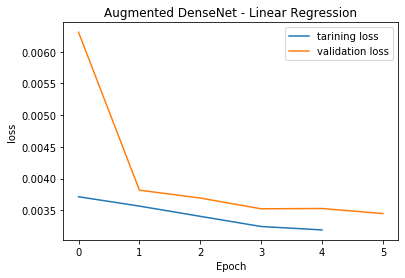

[[3.92601882e-02 2.79390397e-08]
 [4.98329541e-01 0.00000000e+00]
 [5.36470731e-01 0.00000000e+00]
 [5.43768941e-01 0.00000000e+00]
 [5.51300459e-01 0.00000000e+00]
 [5.63593776e-01 0.00000000e+00]]
6


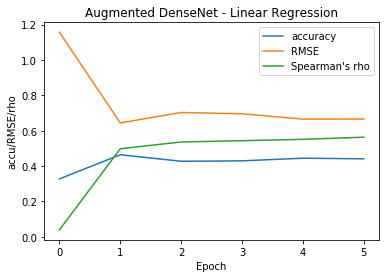

In [87]:
plt.figure()

plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('Augmented DenseNet - Linear Regression')

plt.plot(np.arange(len(training_stats['tarining_loss'])), training_stats['tarining_loss'], label='tarining loss')
plt.plot(np.arange(len(training_stats['validation_loss'])), training_stats['validation_loss'], label='validation loss')

plt.legend()
plt.show()

plt.ylabel('accu/RMSE/rho')
plt.xlabel('Epoch')
plt.title('Augmented DenseNet - Linear Regression')

plt.plot(np.arange(len(training_stats['accuracy'])), training_stats['accuracy'], label='accuracy')
#plt.plot(np.arange(len(training_stats['classification'])), training_stats['classification'], label='')
plt.plot(np.arange(len(training_stats['RMSE'])), training_stats['RMSE'], label='RMSE')
plt.plot(np.arange(len(training_stats['spearmanr'])), [i[0] for i in training_stats['spearmanr']], label="Spearman's rho")

print(np.array(training_stats['spearmanr']))
print(len(np.array(training_stats['spearmanr'])))
plt.legend()
plt.show()

In [29]:
with open('./Resource/Dense_Augmented_Smooth_logdataPaper.pkl', 'wb') as fp:
        pickle.dump(training_stats, fp)

In [28]:
checkpoint = torch.load(open(checkpoint_save_dir + "\DenseNet_Augmented_Binary_Paper_E10A865_10.12.2020_02.37.11.tar", 'rb'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
training_stats = checkpoint['training_stats']

after input. size: torch.Size([2, 64, 56, 56])
after block1. size: torch.Size([2, 128, 28, 28])
after block2. size: torch.Size([2, 256, 14, 14])
after block3. size: torch.Size([2, 640, 7, 7])
after block4. size: torch.Size([2, 1664, 7, 7])
after pooling. size: torch.Size([2, 1664, 1, 1])

.resize_([batch_size, 1])
.resize_([batch_size, 1])